In [1]:
import os
import uproot
import numpy as np

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for branch in branches:
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

branches_list = [
    't4_innerRadius',
    't4_outerRadius',
    't4_pt',
    't4_eta',
    't4_phi',
    't4_isFake',
    't4_t3_idx0',
    't4_t3_idx1',
    't4_pMatched',
    't4_sim_vxy',
    't4_sim_vz',
    't4_rzChiSquared'
]

# Hit-dependent branches
suffixes = ['r', 'z', 'eta', 'phi', 'layer']
branches_list += [f't4_t3_{i}_{suffix}' for i in [0, 2, 4] for suffix in suffixes]

file_path = "../../T4allT3chargecut_T5allcut_dynam_occ_new.root"
# file_path = "t4_PU200_175.root"
branches = load_root_file(file_path, branches_list)

In [2]:
z_max = np.max([np.max(event) for event in branches[f't4_t3_4_z'] if event.size>0])
r_max = np.max([np.max(event) for event in branches[f't4_t3_4_r'] if event.size>0])
eta_max = 2.5
phi_max = np.pi

print(f'Z max: {z_max}, R max: {r_max}, Eta max: {eta_max}')

def delta_phi(phi1, phi2):
    delta = phi1 - phi2
    # Adjust delta to be within the range [-pi, pi]
    if delta > np.pi:
        delta -= 2 * np.pi
    elif delta < -np.pi:
        delta += 2 * np.pi
    return delta

Z max: 267.2349853515625, R max: 110.10993957519531, Eta max: 2.5


In [3]:
features_list = []
eta_list = [] # Used for DNN cut values

for event in range(branches['event']):
    # Determine the number of elements in this event
    num_elements = len(branches['t4_t3_idx0'][event])

    for i in range(num_elements):
        features_iter = []
        eta_iter = []
        
        idx0 = branches['t4_t3_idx0'][event][i]
        idx1 = branches['t4_t3_idx1'][event][i]

        eta1 = np.abs(branches['t4_t3_0_eta'][event][idx0])
        eta2 = np.abs(branches['t4_t3_2_eta'][event][idx0])
        eta3 = np.abs(branches['t4_t3_4_eta'][event][idx0])
        eta4 = np.abs(branches['t4_t3_4_eta'][event][idx1])

        phi1 = (branches['t4_t3_0_phi'][event][idx0])
        phi2 = (branches['t4_t3_2_phi'][event][idx0])
        phi3 = (branches['t4_t3_4_phi'][event][idx0])
        phi4 = (branches['t4_t3_4_phi'][event][idx1])

        z1 = np.abs(branches['t4_t3_0_z'][event][idx0])
        z2 = np.abs(branches['t4_t3_2_z'][event][idx0])
        z3 = np.abs(branches['t4_t3_4_z'][event][idx0])
        z4 = np.abs(branches['t4_t3_4_z'][event][idx1])

        r1 = branches['t4_t3_0_r'][event][idx0]
        r2 = branches['t4_t3_2_r'][event][idx0]
        r3 = branches['t4_t3_4_r'][event][idx0]
        r4 = branches['t4_t3_4_r'][event][idx1]

        innerRad = branches['t4_innerRadius'][event][i]
        outerRad = branches['t4_outerRadius'][event][i]

        rzChiSquared = branches['t4_rzChiSquared'][event][i]

        # Construct the input feature vector using pairwise differences
        features_iter = [
            eta1 / eta_max,                      # First hit eta, normalized
            np.abs(phi1) / phi_max,              # First hit phi, normalized
            z1 / z_max,                          # First hit z, normalized
            r1 / r_max,                          # First hit r, normalized

            eta2 - eta1,                         # Difference in eta between hit 2 and 1
            delta_phi(phi2, phi1) / phi_max,     # Difference in phi between hit 2 and 1
            (z2 - z1) / z_max,                   # Difference in z between hit 2 and 1, normalized
            (r2 - r1) / r_max,                   # Difference in r between hit 2 and 1, normalized

            eta3 - eta2,                         # Difference in eta between hit 3 and 2
            delta_phi(phi3, phi2) / phi_max,     # Difference in phi between hit 3 and 2
            (z3 - z2) / z_max,                   # Difference in z between hit 3 and 2, normalized
            (r3 - r2) / r_max,                   # Difference in r between hit 3 and 2, normalized

            eta4 - eta3,                         # Difference in eta between hit 4 and 3
            delta_phi(phi4, phi3) / phi_max,     # Difference in phi between hit 4 and 3
            (z4 - z3) / z_max,                   # Difference in z between hit 4 and 3, normalized
            (r4 - r3) / r_max,                   # Difference in r between hit 4 and 3, normalized

            np.log10(innerRad),
            np.log10(outerRad),
            np.log10(innerRad/outerRad),
            # rzChiSquared
            # innerRad,
            # outerRad,
            # innerRad/outerRad,
        ]

        # Use the abs eta value of first hit to select cut thresholds
        eta_iter.extend([np.abs(branches['t4_t3_0_eta'][event][idx0])])
        
        # Append the feature vector to the list
        features_list.append(features_iter)
        eta_list.append(eta_iter)

# Convert the list of features to a NumPy array
features = np.array(features_list).T
eta_list = np.array(eta_list).T

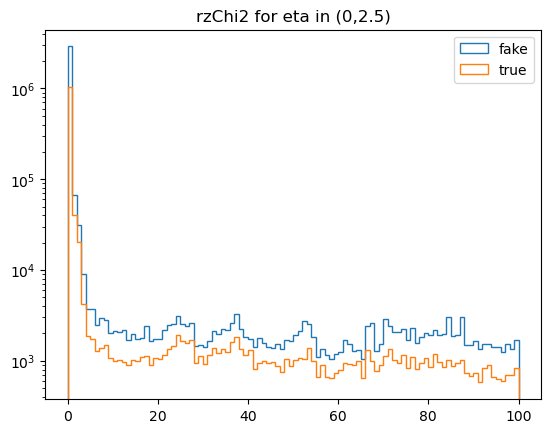

In [ ]:
import matplotlib.pyplot as plt
def plot_feature(features, name, etamin, etamax):
    feature = abs(features[19])
    etas = abs(np.concatenate(eta_list))
    fake_mask = np.concatenate(branches['t4_isFake']) ==1
    true_mask = np.concatenate(branches['t4_isFake']) ==0
    etamask = (etas>etamin)&(etas<etamax)
    fake_etamask = fake_mask&etamask
    true_etamask = true_mask&etamask

    plt.hist(abs(feature[fake_etamask]), bins=100, histtype='step', label='fake', range=(0,100))
    plt.hist(abs(feature[true_etamask]), bins=100, histtype='step', label='true', range=(0,100))
    plt.yscale('log')
    # plt.xlim( 500000)
    plt.title(f'{name}' + ' for eta in (' +  f'{etamin}'+','+f'{etamax}'+ ')')
    plt.legend()
    plt.show()

plot_feature(features, "rzChi2", 0, 2.5 )
# plot_feature(features, "|Log(Inner/Outer Radius)|", .5, 1 )
# plot_feature(features, "|Log(Inner/Outer Radius)|", 1, 1.5 )
# plot_feature(features, "|Log(Inner/Outer Radius)|", 1.5, 2 )
# plot_feature(features, "|Log(Inner/Outer Radius)|", 2, 2.5 )


In [4]:
import torch

# Stack features along a new axis to form a single array suitable for NN input
input_features_numpy = np.stack(features, axis=-1)

# Identify rows with NaN or Inf values
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)

# Apply mask across all columns: retain a row only if all its entries are neither NaN nor Inf
filtered_input_features_numpy = input_features_numpy[np.all(mask, axis=1)]
t4_isFake_filtered = np.concatenate(branches['t4_isFake'])[np.all(mask, axis=1)]

# Convert to PyTorch tensor when ready to use with NN
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)

In [5]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

labels_tensor = 1 - torch.tensor(t4_isFake_filtered, dtype=torch.float32)


class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        # self.layer1 = nn.Linear(input_features_numpy.shape[1], 64) #increase width
        # self.layer2 = nn.Linear(64, 64) #increase width
        # self.layer3 = nn.Linear(64, 64) #add another hidden layer
        # self.layer4 = nn.Linear(64, 64) #add another hidden layer
        self.output_layer = nn.Linear(32, 1)
        # self.output_layer = nn.Linear(64, 1) #increase width

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        # x = self.layer3(x) #add another hidden layer
        # x = nn.ReLU()(x) #add another hidden layer
        # x = self.layer4(x) #add another hidden layer
        # x = nn.ReLU()(x) #add another hidden layer
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor)

Using device: cuda


In [40]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create labels tensor
labels_tensor = 1 - torch.tensor(t4_isFake_filtered, dtype=torch.float32)

# Set initial downsample fraction
initial_downsample_fraction = 1.0  # Adjust this value as needed


class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        # self.layer1 = nn.Linear(input_features_numpy.shape[1], 64) #increase width
        # self.layer2 = nn.Linear(64, 64) #increase width
        # self.layer3 = nn.Linear(64, 64) #add another hidden layer
        # self.layer4 = nn.Linear(64, 64) #add another hidden layer
        self.output_layer = nn.Linear(32, 1)
        # self.output_layer = nn.Linear(64, 1) #increase width

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        # x = self.layer3(x) #add another hidden layer
        # x = nn.ReLU()(x) #add another hidden layer
        # x = self.layer4(x) #add another hidden layer
        # x = nn.ReLU()(x) #add another hidden layer
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x
    
class WeightedBCELoss(nn.Module):
    def __init__(self):
        super(WeightedBCELoss, self).__init__()
        
    def forward(self, outputs, targets, weights):
        eps = 1e-7
        losses = -(weights * (targets * torch.log(outputs + eps) + 
                            (1 - targets) * torch.log(1 - outputs + eps)))
        return losses.mean()

def calculate_sample_weights(t4_pt, t4_sim_vxy, weight_factor=6.0):
    """
    Calculate sample weights giving higher importance to displaced t5's
    
    Args:
        t4_sim_vxy: Array of t4 simulation values
        weight_factor: How much more weight to give to displaced samples
    
    Returns:
        Tensor of sample weights
    """
    
    weights = torch.ones(len(t4_pt[np.all(mask, axis=1)]))
    print(weights.shape)
    highPt_mask = t4_pt[np.all(mask, axis=1)] > 5 
    displaced_mask = t4_sim_vxy[np.all(mask, axis=1)] > 0.1
    weights[displaced_mask] = weight_factor
    weights[highPt_mask] = weight_factor
    return weights

# Print initial dataset size
print(f"Initial dataset size: {len(labels_tensor)}")

# Calculate sample weights
sample_weights = calculate_sample_weights(torch.tensor(np.concatenate(branches['t4_pt'])), torch.tensor(np.concatenate(branches['t4_sim_vxy'])))

# Remove rows with NaN and update weights accordingly
nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor)
print(input_features_tensor.shape, labels_tensor.shape, nan_mask.shape)

filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]
filtered_weights = sample_weights[~nan_mask]

# Initial downsampling of entire dataset
if initial_downsample_fraction < 1.0:
    total_samples = len(filtered_labels)
    samples_to_keep = int(total_samples * initial_downsample_fraction)
    indices = torch.randperm(total_samples)[:samples_to_keep]
    filtered_inputs = filtered_inputs[indices]
    filtered_labels = filtered_labels[indices]
    filtered_weights = filtered_weights[indices]

print(f"Dataset size after initial {initial_downsample_fraction*100}% downsampling: {len(filtered_labels)}")

# Count samples in each class after initial downsampling
class_counts = torch.bincount(filtered_labels.int())
print(f"Class distribution after initial downsampling - Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

# Balance classes while maintaining weights
minority_class = 0 if class_counts[0] < class_counts[1] else 1
minority_indices = (filtered_labels == minority_class).nonzero(as_tuple=True)[0]
majority_indices = (filtered_labels == (1 - minority_class)).nonzero(as_tuple=True)[0]
downsampled_majority_indices = majority_indices[torch.randperm(len(majority_indices))[:len(minority_indices)]] #adjust downsample ratio

balanced_indices = torch.cat((minority_indices, downsampled_majority_indices))

# Create balanced dataset with weights
balanced_inputs = filtered_inputs[balanced_indices]
balanced_labels = filtered_labels[balanced_indices]
balanced_weights = filtered_weights[balanced_indices]

# Verify balanced distribution
balanced_counts = torch.bincount(balanced_labels.int())
print(f"Final class distribution after balancing - Class 0: {balanced_counts[0]}, Class 1: {balanced_counts[1]}")

# Create dataset with weights
dataset = TensorDataset(balanced_inputs, balanced_labels, balanced_weights) 
# dataset = TensorDataset(balanced_inputs, balanced_labels) #no weighting
# dataset = TensorDataset(filtered_inputs, filtered_labels) #no down sample

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=10, pin_memory=True)

# Initialize model and optimizer
model = MyNeuralNetwork().to(device)
loss_function = WeightedBCELoss() #use when add weights
# loss_function = nn.BCELoss() #unweighted
optimizer = Adam(model.parameters(), lr=0.0025)

def evaluate_model(loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets, weights in loader:
        # for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += targets.size(0)
            correct += (predicted == targets.bool()).sum().item()
    model.train()
    return 100 * correct / total

# Training loop
num_epochs = 150
loss_log = []

for epoch in range(num_epochs):
    for inputs, targets, weights in train_loader:
    # for inputs, targets in train_loader:
        inputs, targets, weights = inputs.to(device), targets.to(device), weights.to(device)
        # inputs, targets = inputs.to(device), targets.to(device)

    
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs.squeeze(), targets, weights)
        # loss = loss_function(outputs.squeeze(), targets)
        
        loss_log.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_accuracy = evaluate_model(test_loader)
    # train_accuracy = evaluate_model(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Acc: {test_accuracy:.2f}%')

Using device: cuda
Initial dataset size: 4536947
torch.Size([4536947])
torch.Size([4536947, 20]) torch.Size([4536947]) torch.Size([4536947])
Dataset size after initial 100.0% downsampling: 4536947
Class distribution after initial downsampling - Class 0: 3282234, Class 1: 1254713
Final class distribution after balancing - Class 0: 1254713, Class 1: 1254713
Epoch [1/150], Loss: 0.3954, Test Acc: 86.02%
Epoch [2/150], Loss: 0.4170, Test Acc: 87.02%
Epoch [3/150], Loss: 0.4003, Test Acc: 87.99%
Epoch [4/150], Loss: 0.4499, Test Acc: 89.15%
Epoch [5/150], Loss: 0.3842, Test Acc: 89.67%
Epoch [6/150], Loss: 0.3201, Test Acc: 90.14%
Epoch [7/150], Loss: 0.2925, Test Acc: 90.08%
Epoch [8/150], Loss: 0.3314, Test Acc: 90.60%
Epoch [9/150], Loss: 0.2544, Test Acc: 90.48%
Epoch [10/150], Loss: 0.2952, Test Acc: 91.05%
Epoch [11/150], Loss: 0.2497, Test Acc: 91.15%
Epoch [12/150], Loss: 0.2650, Test Acc: 90.92%
Epoch [13/150], Loss: 0.3141, Test Acc: 90.74%
Epoch [14/150], Loss: 0.3787, Test Acc: 

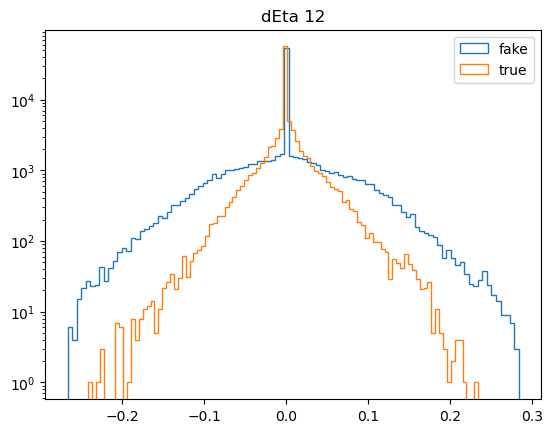

In [8]:
# class_counts = torch.bincount(filtered_labels.int())
# print(f"Class distribution after initial downsampling - Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

# # Balance classes while maintaining weights
# minority_class = 0 if class_counts[0] < class_counts[1] else 1
# minority_indices = (filtered_labels == minority_class).nonzero(as_tuple=True)[0]
# majority_indices = (filtered_labels == (1 - minority_class)).nonzero(as_tuple=True)[0]
# downsampled_majority_indices = majority_indices[torch.randperm(len(majority_indices))[:len(minority_indices)]]

# balanced_indices = torch.cat((minority_indices, downsampled_majority_indices))

# balanced_inputs = filtered_inputs[balanced_indices]
# balanced_labels = filtered_labels[balanced_indices]
# # balanced_weights = filtered_weights[balanced_indices]

# # Verify balanced distribution
# balanced_counts = torch.bincount(balanced_labels.int())
# print(f"Final class distribution after balancing - Class 0: {balanced_counts[0]}, Class 1: {balanced_counts[1]}")


# plotting for feature check 
# balanced_labels
fakes= (balanced_inputs.squeeze() *(balanced_labels==0))
trues = (balanced_inputs.squeeze()*(balanced_labels ==1))

plt.hist(fakes, bins=100, histtype='step', label='fake')
plt.hist(trues, bins=100, histtype='step', label='true')
plt.yscale('log')
plt.title('dEta 12')
# plt.xlim(0,40000)
plt.legend()
plt.show()

In [41]:
# torch.save(model.state_dict(), "model.pth")
torch.save(model.state_dict(), "model_chi2.pth")

In [42]:
from sklearn.metrics import accuracy_score

# Convert tensors to numpy for simplicity in permutation
input_features_np = input_features_tensor.numpy()
labels_np = labels_tensor.numpy()

def model_accuracy(features, labels, model):
    model.eval()  # Set the model to evaluation mode
    inputs = features.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()  # Update threshold as necessary
        accuracy = (predicted == labels).float().mean().item()
    return accuracy

# Use the original input_features_tensor and labels_tensor directly
baseline_accuracy = model_accuracy(input_features_tensor, labels_tensor, model)
print(f"Baseline accuracy: {baseline_accuracy}")

# Initialize an array to store feature importances
feature_importances = np.zeros(input_features_tensor.shape[1])

# Permute each feature and calculate the drop in accuracy
for i in range(input_features_tensor.shape[1]):
    permuted_features = input_features_tensor.clone()
    permuted_features[:, i] = permuted_features[torch.randperm(permuted_features.size(0)), i]  # Permute feature

    permuted_accuracy = model_accuracy(permuted_features, labels_tensor, model)
    feature_importances[i] = baseline_accuracy - permuted_accuracy

# Ranking features by importance
important_features_indices = np.argsort(feature_importances)[::-1]  # Indices of features in descending importance
important_features_scores = np.sort(feature_importances)[::-1]  # Importance scores in descending order

print("Feature importances:")
for idx, score in zip(important_features_indices, important_features_scores):
    print(f"Feature {idx} importance: {score:.4f}")

Baseline accuracy: 0.9062655568122864
Feature importances:
Feature 18 importance: 0.1899
Feature 12 importance: 0.0591
Feature 8 importance: 0.0370
Feature 4 importance: 0.0361
Feature 0 importance: 0.0346
Feature 2 importance: 0.0244
Feature 16 importance: 0.0137
Feature 5 importance: 0.0113
Feature 17 importance: 0.0095
Feature 6 importance: 0.0081
Feature 11 importance: 0.0049
Feature 3 importance: 0.0044
Feature 15 importance: 0.0038
Feature 10 importance: 0.0029
Feature 14 importance: 0.0007
Feature 1 importance: -0.0000
Feature 7 importance: -0.0001
Feature 13 importance: -0.0006
Feature 19 importance: -0.0007
Feature 9 importance: -0.0008


/tmp/ipykernel_2591243/1073338706.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


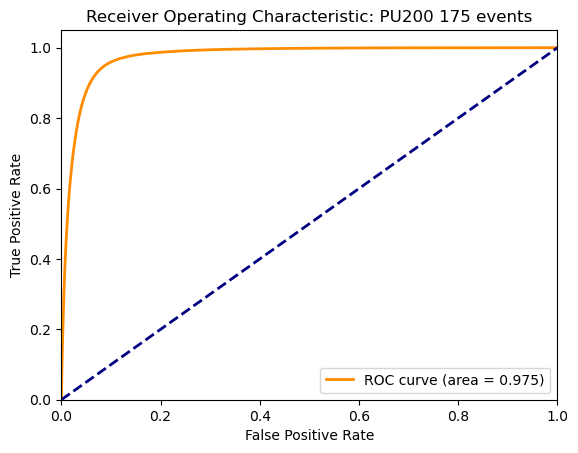

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def model_outputs(features, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        inputs = torch.tensor(features, dtype=torch.float32).to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
    return outputs

# Calculate model outputs
probabilities = model_outputs(filtered_inputs, model)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(filtered_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic: PU200 175 events')
plt.legend(loc="lower right")
plt.show()

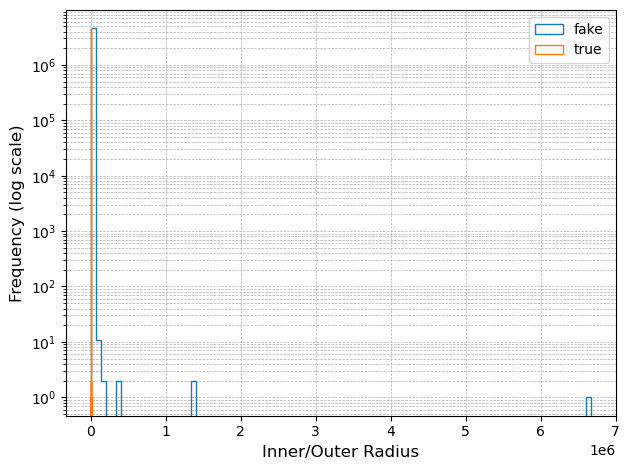

In [10]:

def plot_features(features):
    fake_mask = t4_isFake_filtered
    perfect_mask = (t4_isFake_filtered == 0)* (np.concatenate(branches['t4_pMatched']) > 0.95)
    plt.hist(features, bins=100, histtype='step', linewidth=1.5, label='<75% match')  # Outline only, no fill
    # plt.hist(features[perfect_mask], bins=100, histtype='step', linewidth=1.5, label='100% match')  # Outline only, no fill
    plt.yscale('log')
    plt.xlabel("Inner/Outer Radius", fontsize=12)
    plt.ylabel("Frequency (log scale)", fontsize=12)
    # plt.title("DNN Score", fontsize=14, weight='bold')
    plt.legend()

    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# plot_features(features)

rad_rat_fake=( np.concatenate(branches['t4_isFake']) == 1)* ((np.concatenate(branches['t4_innerRadius'])/np.concatenate(branches['t4_outerRadius'])))
rad_rat_true = ( np.concatenate(branches['t4_isFake']) == 0)* ((np.concatenate(branches['t4_innerRadius'])/np.concatenate(branches['t4_outerRadius']))) 
plt.hist(rad_rat_fake, bins=100,histtype='step', label="fake")
plt.hist(rad_rat_true, bins=100, histtype='step', label="true")
plt.yscale('log')
plt.xlabel("Inner/Outer Radius", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
    # plt.title("DNN Score", fontsize=14, weight='bold')
plt.legend()
# plt.xlim(0,50000)

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Prediction scores:
Mean score: 0.3553
Median score: 0.0574


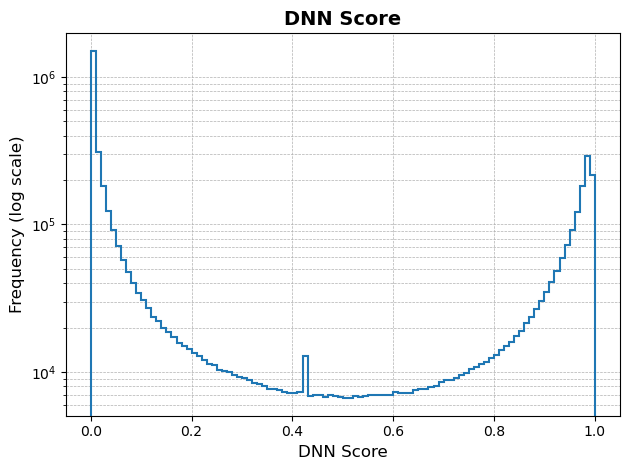

In [44]:
# Get model predictions
# probabilities = model_outputs(filtered_inputs, model)



# Calculate statistics for displaced tracks
mean_score = np.mean(probabilities)
median_score = np.median(probabilities)

print(f"Prediction scores:")
print(f"Mean score: {mean_score:.4f}")
print(f"Median score: {median_score:.4f}")

plt.hist(probabilities, bins=100, histtype='step', linewidth=1.5)  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score", fontsize=14, weight='bold')

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

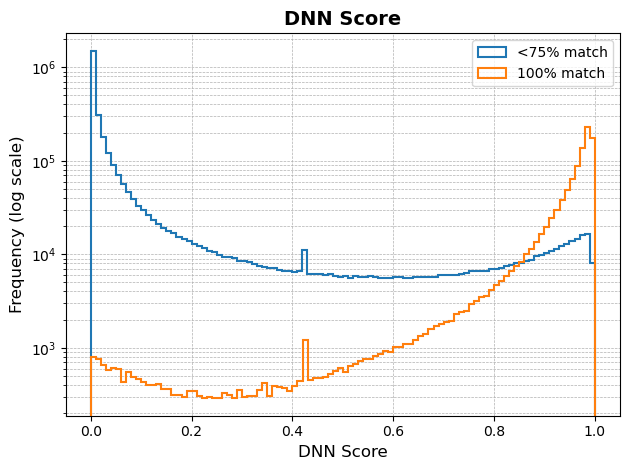

In [47]:
labels_tensor = 1 - torch.tensor(t4_isFake_filtered, dtype=torch.float32)
nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor)
fake_mask = np.concatenate(branches['t4_isFake'])[np.all(mask, axis=1)][~nan_mask] == 1
perfect_mask = (np.concatenate(branches['t4_isFake'])[np.all(mask, axis=1)][~nan_mask] == 0)* (np.concatenate(branches['t4_pMatched'])[np.all(mask, axis=1)] > 0.95)
plt.hist(probabilities[fake_mask], bins=100, histtype='step', linewidth=1.5, label='<75% match')  # Outline only, no fill
plt.hist(probabilities[perfect_mask], bins=100, histtype='step', linewidth=1.5, label='100% match')  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score", fontsize=14, weight='bold')
plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
#old

In [45]:
labels_tensor = 1 - torch.tensor(t4_isFake_filtered, dtype=torch.float32)
nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor)
fake_mask = np.concatenate(branches['t4_isFake'])[~nan_mask] == 1
perfect_mask = (np.concatenate(branches['t4_isFake'])[~nan_mask] == 0)* (np.concatenate(branches['t4_pMatched']) > 0.95)
plt.hist(probabilities[fake_mask], bins=100, histtype='step', linewidth=1.5, label='<75% match')  # Outline only, no fill
plt.hist(probabilities[perfect_mask], bins=100, histtype='step', linewidth=1.5, label='100% match')  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score", fontsize=14, weight='bold')
plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
#with chi2


IndexError: boolean index did not match indexed array along axis 0; size of axis is 4555984 but size of corresponding boolean axis is 4536947

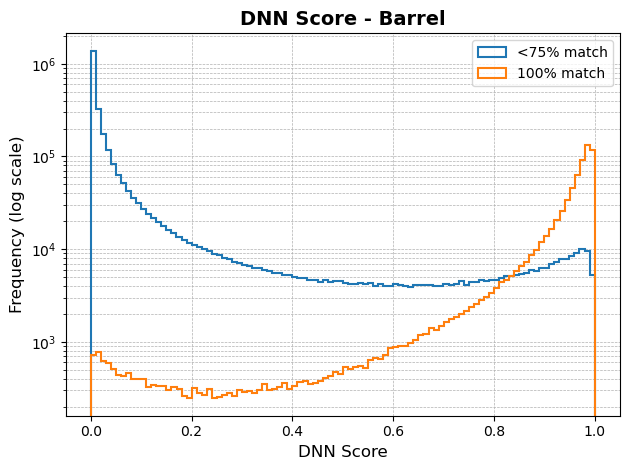

In [12]:
barrel_fake_mask = (np.concatenate(branches['t4_isFake'])[~nan_mask] == 1)*(np.concatenate(branches['t4_eta'])<1)
barrel_perfect_mask = (np.concatenate(branches['t4_isFake'])[~nan_mask] == 0)* (np.concatenate(branches['t4_pMatched']) > 0.95)*(np.concatenate(branches['t4_eta'])<1)
plt.hist(probabilities[barrel_fake_mask], bins=100, histtype='step', linewidth=1.5, label='<75% match')  # Outline only, no fill
plt.hist(probabilities[barrel_perfect_mask], bins=100, histtype='step', linewidth=1.5, label='100% match')  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score - Barrel", fontsize=14, weight='bold')
plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

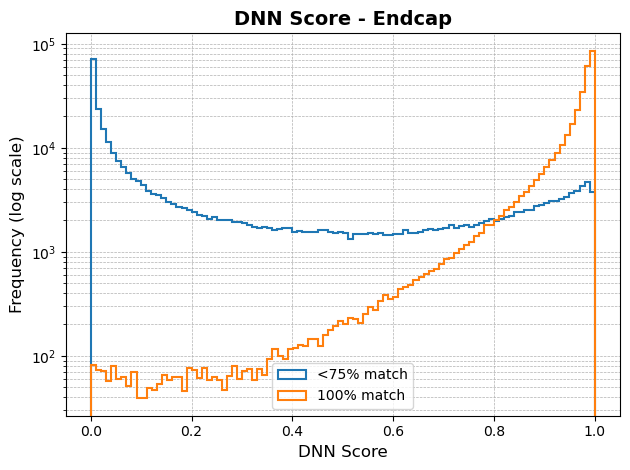

In [13]:
endcap_fake_mask = (np.concatenate(branches['t4_isFake'])[~nan_mask] == 1)*(np.concatenate(branches['t4_eta'])>1)
endcap_perfect_mask = (np.concatenate(branches['t4_isFake'])[~nan_mask] == 0)* (np.concatenate(branches['t4_pMatched']) > 0.95)*(np.concatenate(branches['t4_eta'])>1)
plt.hist(probabilities[endcap_fake_mask], bins=100, histtype='step', linewidth=1.5, label='<75% match')  # Outline only, no fill
plt.hist(probabilities[endcap_perfect_mask], bins=100, histtype='step', linewidth=1.5, label='100% match')  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score - Endcap", fontsize=14, weight='bold')
plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [83]:
def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()

    # Print weights
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()

def print_model_weights_biases(model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Iterate through all named modules in the model
    for name, module in model.named_modules():
        # Check if the module is a linear layer
        if isinstance(module, nn.Linear):
            # Get weights and biases
            weights = module.weight.data.cpu().numpy()
            biases = module.bias.data.cpu().numpy()

            # Print formatted weights and biases
            print_formatted_weights_biases(weights, biases, name.replace('.', '_'))

print_model_weights_biases(model)


ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_layer1[32] = {
-2.6772404f, 1.7541034f, -12.4007473f, -2.1517622f, 0.4400636f, 0.8299164f, -7.7062960f, -2.7090561f, 4.8764563f, 2.4223630f, 3.2249484f, 0.0325309f, 0.7268249f, 0.0904248f, -0.2657492f, -0.5831257f, -0.3447608f, -1.1923949f, -0.1809838f, 3.0033948f, -2.5253065f, -1.1171492f, 1.0150151f, 0.2428089f, 0.7011787f, -0.9885314f, -10.1924019f, -5.0982208f, 1.8601061f, -5.1125817f, -2.9922245f, -1.4484043f };

ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_layer1[20][32] = {
{ 0.7495517f, 2.4798455f, -24.1380138f, -0.1784073f, 1.8087715f, -0.1002793f, -8.7291908f, 0.8388988f, -1.5498552f, 1.5595005f, -1.1729577f, 0.4785659f, 1.4903065f, 0.0126164f, -0.4978376f, -1.5460030f, -1.1399686f, 2.7764423f, -1.7079393f, -0.6068117f, -3.5743291f, 0.1626776f, 0.4271252f, 0.5588350f, 1.1810566f, -1.5671573f, -16.6634827f, -10.0143042f, 0.1236996f, -7.8816080f, -0.1595559f, -1.9338913f },
{ 0.0501234f, 0.0060211f, -13.0871773f, -0.2716640f, 0.009

In [6]:
model = MyNeuralNetwork().to(device)
model.load_state_dict(torch.load("model_weightedPt_displaced.pth", map_location=torch.device('cpu')))

/tmp/ipykernel_3175973/996816760.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weightedPt_displaced.pth", map_location=torch.de

<All keys matched successfully>

In [7]:
# Ensure input_features_tensor is moved to the appropriate device
input_features_tensor = input_features_tensor.to(device)
filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]

# Make predictions
with torch.no_grad():
    model.eval()
    outputs = model(input_features_tensor)
    predictions = outputs.squeeze().cpu().numpy()

full_tracks = (np.concatenate(branches['t4_isFake'])[np.all(mask, axis=1)] == 0) * (np.concatenate(branches['t4_pMatched'])[np.all(mask, axis=1)] > 0.95)


In [8]:
def model_outputs(features, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        inputs = torch.tensor(features, dtype=torch.float32).to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
    return outputs

# Calculate model outputs
probabilities = model_outputs(filtered_inputs, model)

/tmp/ipykernel_3175973/3296547289.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


In [76]:
predictions.shape

(4536947,)

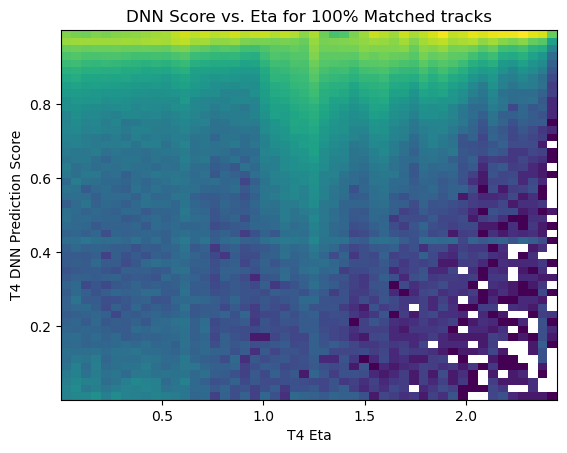

In [63]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# full_tracks =  (np.concatenate(branches['t4_pMatched']) > 0.95) 
plt.hist2d(eta_list[0][np.all(mask, axis=1)][full_tracks], predictions[full_tracks], bins=[50,50], norm=LogNorm())
plt.xlabel("T4 Eta")
plt.ylabel("T4 DNN Prediction Score")
plt.title("DNN Score vs. Eta for 100% Matched tracks")
# plt.colorbar()
plt.show()

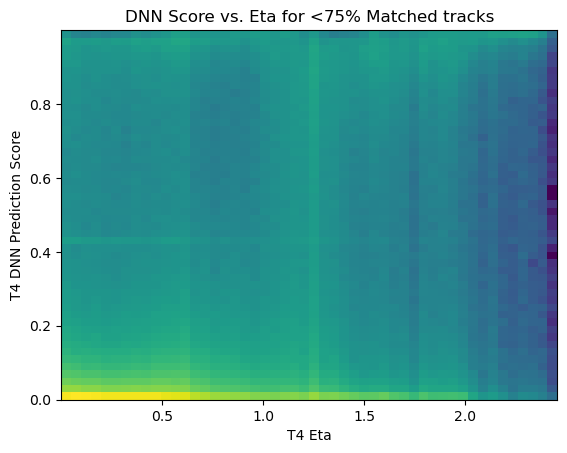

In [64]:
from matplotlib.colors import LogNorm
fake_tracks = (np.concatenate(branches['t4_isFake'])[np.all(mask, axis=1)] ==1) 
# full_tracks =  (np.concatenate(branches['t4_pMatched']) > 0.95) 
plt.hist2d(eta_list[0][np.all(mask, axis=1)][fake_tracks], predictions[fake_tracks], bins=[50,50], norm=LogNorm())
plt.xlabel("T4 Eta")
plt.ylabel("T4 DNN Prediction Score")
plt.title("DNN Score vs. Eta for <75% Matched tracks")
# plt.colorbar()
plt.show()

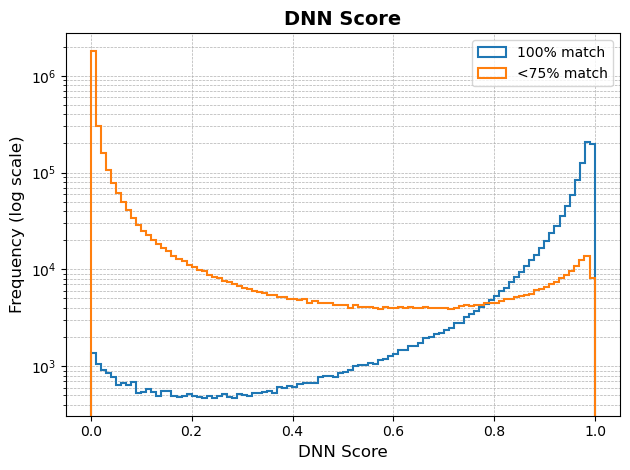

In [43]:
# mean_score = np.mean(probabilities)
# median_score = np.median(probabilities)

# print(f"Prediction scores:")
# print(f"Mean score: {mean_score:.4f}")
# print(f"Median score: {median_score:.4f}")

plt.hist(predictions[full_tracks], bins=100, histtype='step', linewidth=1.5, label='100% match')
plt.hist(predictions[fake_tracks], bins=100, histtype='step', linewidth=1.5, label='<75% match')  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score", fontsize=14, weight='bold')
plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [78]:
[full_tracks & (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] > 1) & 
                                    (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] <= 2)]

ValueError: operands could not be broadcast together with shapes (4555984,) (4536947,) 

In [79]:
[(np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] > 1) & 
                                    (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] <= 2)]

[array([ True,  True,  True, ...,  True,  True,  True])]

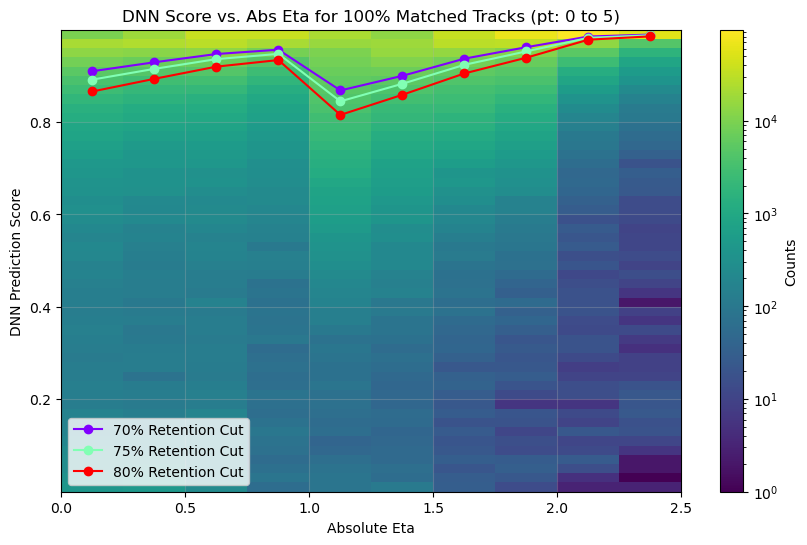


pt: 0 to 5
70% Retention Cut: {0.91, 0.9293, 0.9472, 0.9565, 0.8684, 0.9, 0.9372, 0.962, 0.9851, 0.9893} Mean: 0.9385
75% Retention Cut: {0.8918, 0.9151, 0.9362, 0.9475, 0.8448, 0.8828, 0.9238, 0.9529, 0.9823, 0.9878} Mean: 0.9265
80% Retention Cut: {0.8661, 0.8935, 0.9199, 0.9341, 0.8154, 0.859, 0.9052, 0.9393, 0.9783, 0.9854} Mean: 0.9096


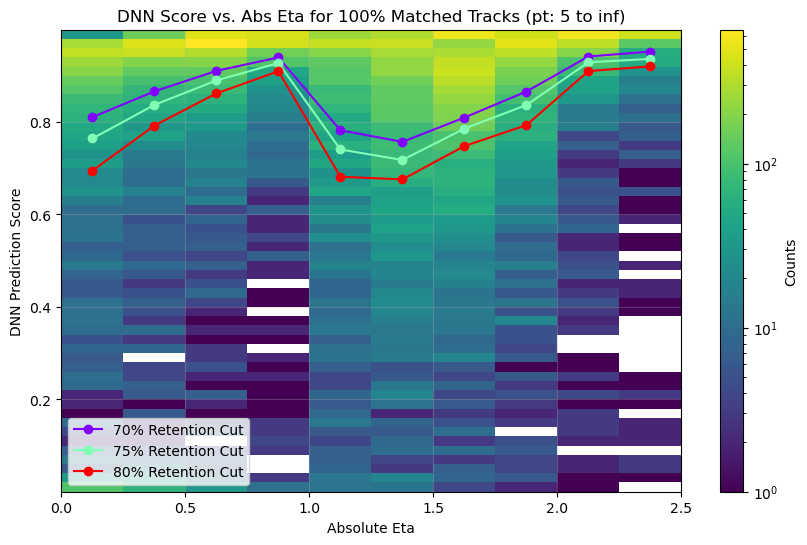


pt: 5 to inf
70% Retention Cut: {0.8105, 0.8663, 0.9106, 0.9397, 0.7822, 0.7571, 0.8097, 0.8659, 0.9417, 0.9523} Mean: 0.8636
75% Retention Cut: {0.7644, 0.837, 0.8899, 0.9275, 0.7406, 0.718, 0.7857, 0.8366, 0.9292, 0.9365} Mean: 0.8365
80% Retention Cut: {0.6948, 0.7923, 0.8618, 0.9099, 0.6816, 0.6759, 0.748, 0.7932, 0.9101, 0.9204} Mean: 0.7988


In [10]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
# full_tracks = (np.concatenate(branches['t4_isFake']) == 0) * (np.concatenate(branches['t4_pMatched']) > 0.95)

def plot_for_pt_bin(pt_min, pt_max, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Calculate and plot cut values for specified percentiles in a given pt bin
    
    Parameters:
    -----------
    pt_min : float
        Minimum pt value for the bin
    pt_max : float
        Maximum pt value for the bin
    percentiles : list
        List of percentiles to calculate (e.g., [92.5, 96.7, 99])
    eta_bin_edges : array
        Edges of the eta bins
    eta_list : list
        List of eta values
    predictions : array
        Array of DNN predictions
    full_tracks : array
        Boolean array for track selection
    branches : dict
        Dictionary containing branch data
    """
    # Filter data based on pt bin
    abs_eta = eta_list[0][np.all(mask, axis=1)][full_tracks & (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] > pt_min) & 
                         (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] <= pt_max)]
    predictions_filtered = predictions[full_tracks & (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] > pt_min) & 
                                    (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] <= pt_max)]
    
    # Dictionary to store cut values for different percentiles
    cut_values = {p: [] for p in percentiles}

    # Loop through each eta bin
    for i in range(len(eta_bin_edges) - 1):
        # Get indices of tracks within the current eta bin
        bin_indices = (abs_eta >= eta_bin_edges[i]) & (abs_eta < eta_bin_edges[i + 1])
        
        # Get the corresponding DNN prediction scores
        bin_predictions = predictions_filtered[bin_indices]
        
        # Calculate the percentile cut values for the current bin
        for percentile in percentiles:
            cut_value = np.percentile(bin_predictions, 100 - percentile)  # Convert retention to percentile
            cut_values[percentile].append(cut_value)

    # Plot 2D histogram
    plt.figure(figsize=(10, 6))
    plt.hist2d(abs_eta, predictions_filtered, bins=[eta_bin_edges, 50], norm=LogNorm())
    plt.colorbar(label='Counts')
    plt.xlabel("Absolute Eta")
    plt.ylabel("DNN Prediction Score")
    plt.title(f"DNN Score vs. Abs Eta for 100% Matched Tracks (pt: {pt_min} to {pt_max})")

    # Plot the cut values with different colors
    cut_x = eta_bin_edges[:-1] + (eta_bin_edges[1] - eta_bin_edges[0]) / 2  # Mid-points of the bins
    colors = plt.cm.rainbow(np.linspace(0, 1, len(percentiles)))  # Generate distinct colors
    
    for percentile, color in zip(percentiles, colors):
        plt.plot(cut_x, cut_values[percentile], '-', color=color, marker='o', 
                label=f'{percentile}% Retention Cut')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print the cut values
    print(f"\npt: {pt_min} to {pt_max}")
    for percentile in percentiles:
        values = cut_values[percentile]
        print(f"{percentile}% Retention Cut:", 
              '{' + ', '.join(str(x) for x in np.round(values, 4)) + '}',
              "Mean:", np.round(np.mean(values), 4))

# Example usage:
def analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Analyze and plot for multiple pt bins and percentiles
    
    Parameters:
    -----------
    pt_bins : list
        List of pt bin edges
    percentiles : list
        List of percentiles to calculate
    Other parameters same as plot_for_pt_bin function
    """
    for i in range(len(pt_bins) - 1):
        plot_for_pt_bin(pt_bins[i], pt_bins[i + 1], percentiles, eta_bin_edges, 
                       eta_list, predictions, full_tracks, branches)

# Example call:
percentiles = [70, 75, 80]
pt_bins = [0, 5, np.inf]
eta_bin_edges = np.arange(0, 2.75, 0.25)
analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches)

/tmp/ipykernel_1949115/3296547289.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


Prediction scores for high pt tracks (t4_pt > 5):
Mean score: 0.1020
Median score: 0.0030


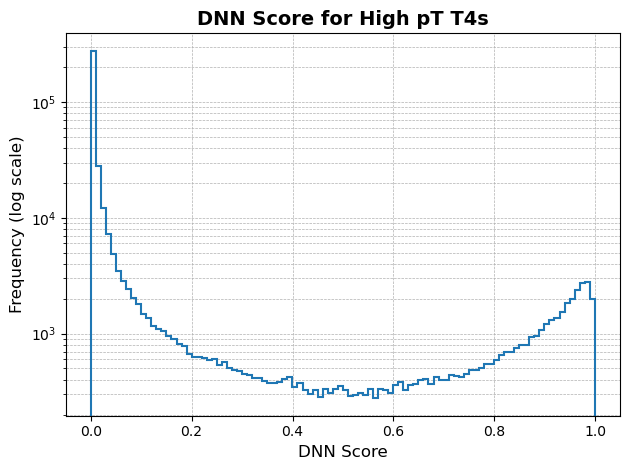

In [25]:
probabilities = model_outputs(filtered_inputs, model)

# Get displaced track mask
highPt_mask = np.concatenate(branches['t4_pt'])[~nan_mask] > 5

# Calculate statistics for displaced tracks
highpt_predictions = probabilities[highPt_mask]
mean_score = np.mean(highpt_predictions)
median_score = np.median(highpt_predictions)

print(f"Prediction scores for high pt tracks (t4_pt > 5):")
print(f"Mean score: {mean_score:.4f}")
print(f"Median score: {median_score:.4f}")

plt.hist(highpt_predictions, bins=100, histtype='step', linewidth=1.5)  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score for High pT T4s", fontsize=14, weight='bold')

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

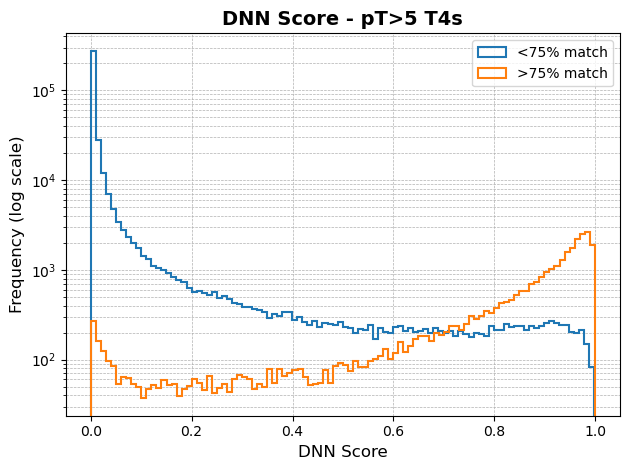

In [26]:
highpt_fake_mask = (np.concatenate(branches['t4_isFake'])[~nan_mask] == 1)*(np.concatenate(branches['t4_pt'])>5)
highpt_true_mask = (np.concatenate(branches['t4_isFake'])[~nan_mask] == 0)*(np.concatenate(branches['t4_pt'])>5)

plt.hist(probabilities[highpt_fake_mask], bins=100, histtype='step', linewidth=1.5, label='<75% match')  # Outline only, no fill
plt.hist(probabilities[highpt_true_mask], bins=100, histtype='step', linewidth=1.5, label='>75% match')  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score - pT>5 T4s", fontsize=14, weight='bold')
plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

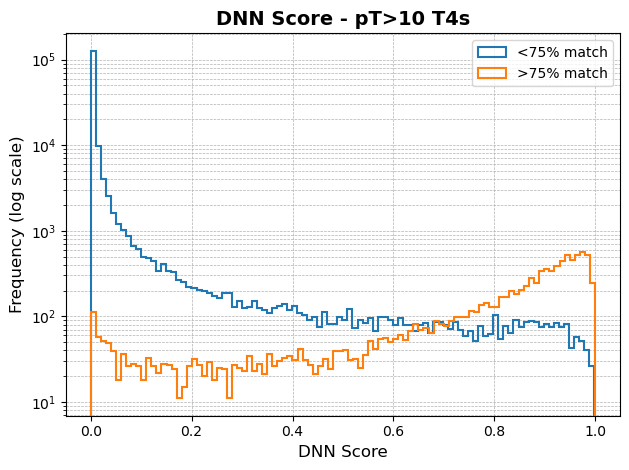

In [27]:
highpt_fake_mask = (np.concatenate(branches['t4_isFake'])[~nan_mask] == 1)*(np.concatenate(branches['t4_pt'])>10)
highpt_true_mask = (np.concatenate(branches['t4_isFake'])[~nan_mask] == 0)*(np.concatenate(branches['t4_pt'])>10)

plt.hist(probabilities[highpt_fake_mask], bins=100, histtype='step', linewidth=1.5, label='<75% match')  # Outline only, no fill
plt.hist(probabilities[highpt_true_mask], bins=100, histtype='step', linewidth=1.5, label='>75% match')  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score - pT>10 T4s", fontsize=14, weight='bold')
plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

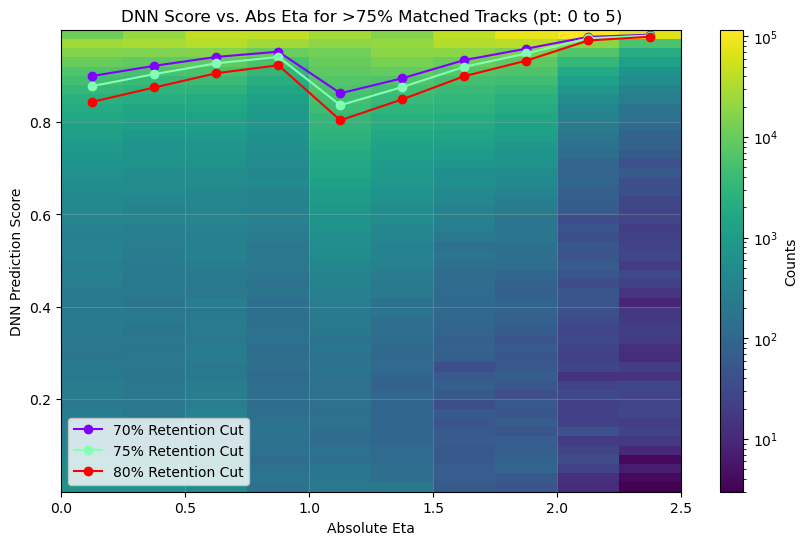


pt: 0 to 5
70% Retention Cut: {0.8997, 0.9217, 0.9409, 0.9522, 0.8622, 0.8948, 0.9341, 0.9588, 0.9843, 0.9889} Mean: 0.9338
75% Retention Cut: {0.8778, 0.9037, 0.9272, 0.9409, 0.8365, 0.8758, 0.9195, 0.9484, 0.9812, 0.9872} Mean: 0.9198
80% Retention Cut: {0.8438, 0.8748, 0.9057, 0.9229, 0.8037, 0.8492, 0.8993, 0.9328, 0.9766, 0.9846} Mean: 0.8993


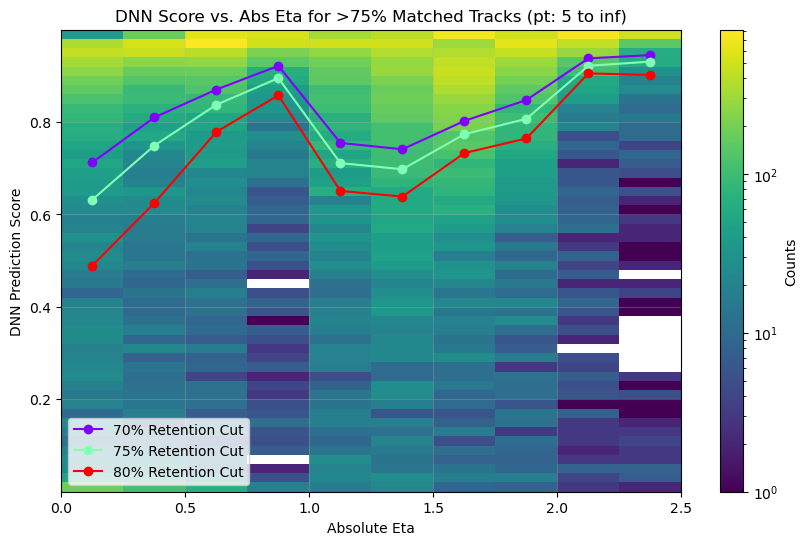


pt: 5 to inf
70% Retention Cut: {0.7126, 0.81, 0.8702, 0.9215, 0.7548, 0.7409, 0.8023, 0.8475, 0.9377, 0.9447} Mean: 0.8342
75% Retention Cut: {0.632, 0.7491, 0.8374, 0.8949, 0.7111, 0.6977, 0.7736, 0.8068, 0.9217, 0.9306} Mean: 0.7955
80% Retention Cut: {0.4895, 0.6248, 0.7787, 0.8577, 0.651, 0.6386, 0.7328, 0.7644, 0.9051, 0.9018} Mean: 0.7344


In [11]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
# full_tracks = (np.concatenate(branches['t4_isFake']) == 0) * (np.concatenate(branches['t4_pMatched']) > 0.95)
true_tracks = (np.concatenate(branches['t4_isFake'])[np.all(mask, axis=1)] == 0) 

def plot_for_pt_bin_alltrue(pt_min, pt_max, percentiles, eta_bin_edges, eta_list, predictions, true_tracks, branches):
    """
    Calculate and plot cut values for specified percentiles in a given pt bin
    
    Parameters:
    -----------
    pt_min : float
        Minimum pt value for the bin
    pt_max : float
        Maximum pt value for the bin
    percentiles : list
        List of percentiles to calculate (e.g., [92.5, 96.7, 99])
    eta_bin_edges : array
        Edges of the eta bins
    eta_list : list
        List of eta values
    predictions : array
        Array of DNN predictions
    full_tracks : array
        Boolean array for track selection
    branches : dict
        Dictionary containing branch data
    """
    # Filter data based on pt bin
    abs_eta = eta_list[0][np.all(mask, axis=1)][true_tracks & (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] > pt_min) & 
                         (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] <= pt_max)]
    predictions_filtered = predictions[true_tracks & (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] > pt_min) & 
                                    (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] <= pt_max)]
    
    # Dictionary to store cut values for different percentiles
    cut_values = {p: [] for p in percentiles}

    # Loop through each eta bin
    for i in range(len(eta_bin_edges) - 1):
        # Get indices of tracks within the current eta bin
        bin_indices = (abs_eta >= eta_bin_edges[i]) & (abs_eta < eta_bin_edges[i + 1])
        
        # Get the corresponding DNN prediction scores
        bin_predictions = predictions_filtered[bin_indices]
        
        # Calculate the percentile cut values for the current bin
        for percentile in percentiles:
            cut_value = np.percentile(bin_predictions, 100 - percentile)  # Convert retention to percentile
            cut_values[percentile].append(cut_value)

    # Plot 2D histogram
    plt.figure(figsize=(10, 6))
    plt.hist2d(abs_eta, predictions_filtered, bins=[eta_bin_edges, 50], norm=LogNorm())
    plt.colorbar(label='Counts')
    plt.xlabel("Absolute Eta")
    plt.ylabel("DNN Prediction Score")
    plt.title(f"DNN Score vs. Abs Eta for >75% Matched Tracks (pt: {pt_min} to {pt_max})")

    # Plot the cut values with different colors
    cut_x = eta_bin_edges[:-1] + (eta_bin_edges[1] - eta_bin_edges[0]) / 2  # Mid-points of the bins
    colors = plt.cm.rainbow(np.linspace(0, 1, len(percentiles)))  # Generate distinct colors
    
    for percentile, color in zip(percentiles, colors):
        plt.plot(cut_x, cut_values[percentile], '-', color=color, marker='o', 
                label=f'{percentile}% Retention Cut')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print the cut values
    print(f"\npt: {pt_min} to {pt_max}")
    for percentile in percentiles:
        values = cut_values[percentile]
        print(f"{percentile}% Retention Cut:", 
              '{' + ', '.join(str(x) for x in np.round(values, 4)) + '}',
              "Mean:", np.round(np.mean(values), 4))

# Example usage:
def analyze_pt_bins_alltrue(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, true_tracks, branches):
    """
    Analyze and plot for multiple pt bins and percentiles
    
    Parameters:
    -----------
    pt_bins : list
        List of pt bin edges
    percentiles : list
        List of percentiles to calculate
    Other parameters same as plot_for_pt_bin function
    """
    for i in range(len(pt_bins) - 1):
        plot_for_pt_bin_alltrue(pt_bins[i], pt_bins[i + 1], percentiles, eta_bin_edges, 
                       eta_list, predictions, true_tracks, branches)

# Example call:
percentiles = [70, 75, 80]
pt_bins = [0, 5, np.inf]
eta_bin_edges = np.arange(0, 2.75, 0.25)
analyze_pt_bins_alltrue(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, true_tracks, branches)